**To do list:**
- Add column names for header and df_SERAC/SERAC_dic
- Extend functions by adding parameters: e.g. Partition.detect_outlier select mean or median
- Modify plot functions to make create informed figures...
- Raise error...
- Add comments, create Read the docs  
- IMAU December 2020, GSFC Sepetember 2021

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import ProcessSERAC
import matplotlib.pyplot as plt

In [7]:
SERAC_dir = "/Users/huigao/Desktop/Mass_reconstruction/Annual_thickness_reconstruction/Partition_SERAC2022/"

FDM_IMAU2020 = "/Volumes/Samsung_T5/Greenland_climatology/RACMO/IMAUFDM_RACMO2.3p2_1960-2020/FDM_zs_FGRN055_1957-2020_GrIS_GIC_SERACInput.csv"
FDM_GSFC = "/Volumes/Samsung_T5/Greenland_climatology/MERRA_2/gsfc_fdm_v1.2/gsfc_fdm_v1_2_1_gris_June22_SERACInput.csv"
FDM_MAR = "/Volumes/Samsung_T5/Greenland_climatology/MAR/MARv3.12.1-6.5km-daily-ERA5_SERACInput.csv"


tile_id = 6
FDM_source = "MAR" # or "IMAU"
save_FDM_txt = False
save_partition_txt = True

output_FDM = SERAC_dir+"FDM"+FDM_source+"_"+"Tile"+str(tile_id)+".txt"
output_FDMstd = SERAC_dir+"FDMstd"+FDM_source+"_"+"Tile"+str(tile_id)+".txt"
output_f = SERAC_dir+"TimeSeriesTile"+str(tile_id)+"_partitioned_"+FDM_source+".txt"


SERAC = ProcessSERAC.Read(SERAC_dir+"TimeSeriesTile"+str(tile_id)+".txt", skiprows = [0, 1]) 
header, SERAC_dic = SERAC.return_raw()

S_partition = ProcessSERAC.Partition(header, SERAC_dic) ## Partition raw SERAC data

In [8]:
outlier_flag = S_partition.detect_outlier()  # True: good data; False: outliers

f_geoid = SERAC_dir+'Greenland16/ggeoid16.tif'
header_with_geoid = S_partition.get_geoid_height(f_geoid)

flags = S_partition.flagging(outlier_flag = outlier_flag, threshold = 10, plot_code = [3, 4])

CPU times: user 6min 53s, sys: 2min 23s, total: 9min 16s
Wall time: 14min 22s


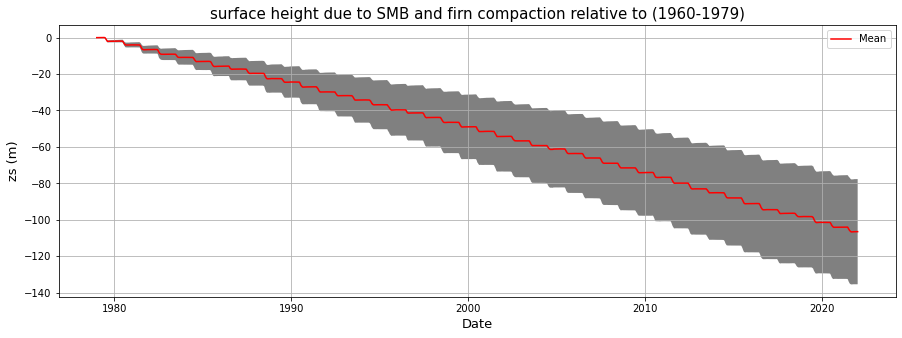

In [9]:
%%time

## Extract time series of FDM at SERAC locations and partition total elevation change

if FDM_source == "IMAU":
    FDM_fname = FDM_IMAU2020
if FDM_source == "GSFC":
    FDM_fname = FDM_GSFC 
if FDM_source == "MAR":
    FDM_fname = FDM_MAR



time_fdm, fdm_serac, fdm_serac_std = S_partition.extract_FDM(FDM_fname, n = 4, plot_n = 0, 
                                                             save_FDM_txt = save_FDM_txt, output_FDM = output_FDM, output_FDMstd = output_FDMstd)
h_fdm, h_fdm_std, d_h_result, err_d_h = S_partition.partition_FDM(time_fdm, fdm_serac, fdm_serac_std)



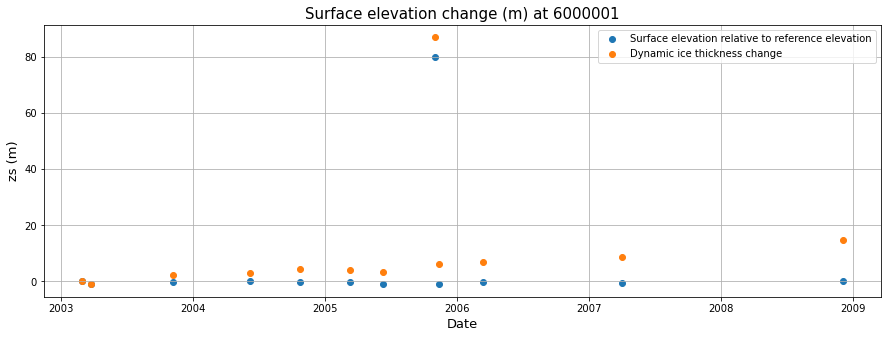

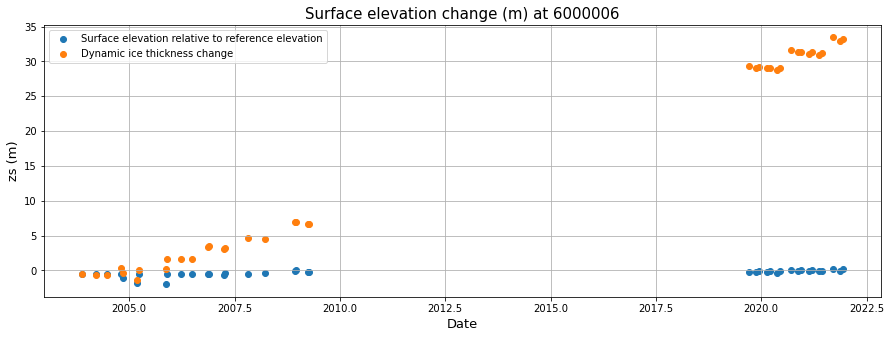

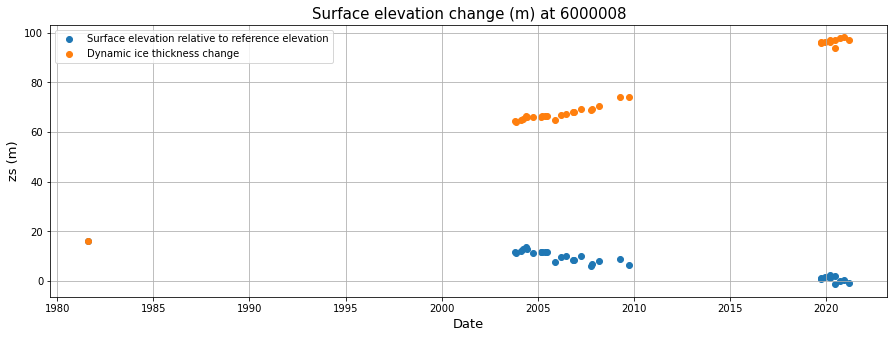

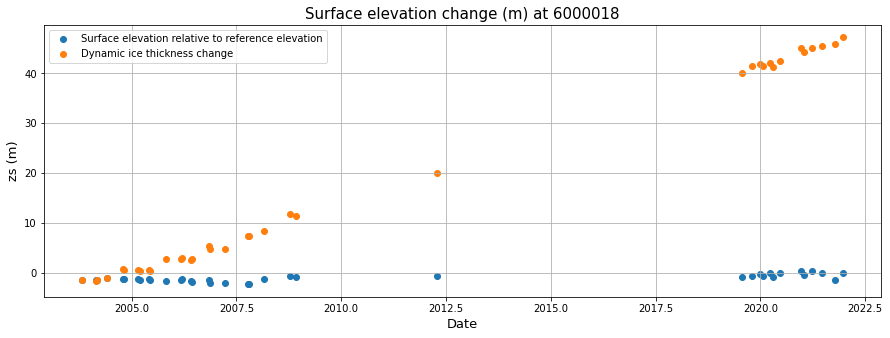

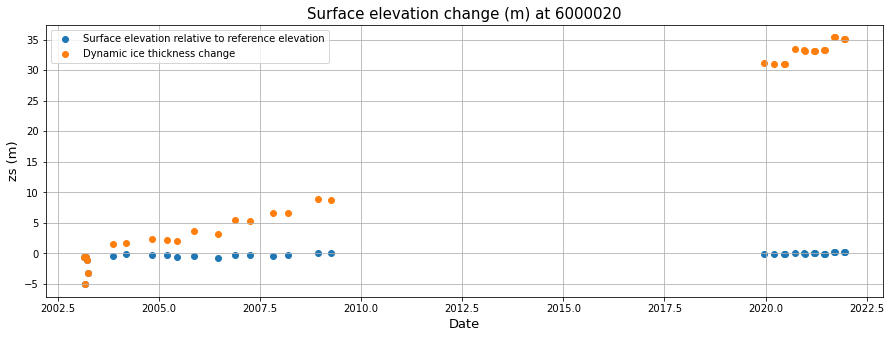

In [10]:
## Plot partitioning results
t_serac = ProcessSERAC.get_SERAC_column(SERAC_dic, 1)
rel_h = ProcessSERAC.get_SERAC_column(SERAC_dic, 4)

for k in range(0, 5):
    d_h = d_h_result[k].copy()
    d_h[d_h == -999.] = np.nan
    fig, ax = plt.subplots(figsize = (15,5))
    ax.scatter(t_serac[k], rel_h[k], label = 'Surface elevation relative to reference elevation')
    ax.scatter(t_serac[k], d_h, label = 'Dynamic ice thickness change')
    ax.set_xlabel('Date',fontsize = 13)
    ax.set_ylabel('zs (m)', fontsize = 13)
    ax.set_title('Surface elevation change (m) at '+str(header.iloc[k, 0]), fontsize=15)
    ax.legend()
    ax.grid(True)


In [17]:
if save_partition_txt:
    S_partition.save_txt(output_f, add_flag = True)